# Import packages

In [1]:
import torch
import torch.nn as nn
import torchdiffeq
from torchdiffeq import odeint
from xitorch.interpolate import Interp1D
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

In [4]:
# Generate x and y in y = log(x)
log_V_range = [-15, 2]
N_seq = 12000
y = torch.rand([N_seq, 1]) * (log_V_range[1] - log_V_range[0]) + log_V_range[0]
x = torch.pow(10., y)

from torch.utils.data import TensorDataset, DataLoader
AllData = TensorDataset(
    x, 
    y,
)

# Training-testing separation
trainSetLen = int(len(AllData) * 0.8)
testSetLen = len(AllData) - trainSetLen

# Separate the data set
trainDataSet, testDataSet = torch.utils.data.random_split(AllData, [trainSetLen, testSetLen])
print('Training data set length: ', len(trainDataSet))
print('Testing data set length: ', len(testDataSet))

# Training data loader
training_batch_size = 256 * 4
trainDataLoader = DataLoader(
    trainDataSet,
    batch_size = training_batch_size,
    shuffle = True,
#    num_workers = 16,
    collate_fn = None,
    pin_memory = False,
)

# Testing data loader
testing_batch_size = 64 * 4
testDataLoader = DataLoader(
    testDataSet,
    batch_size = testing_batch_size,
    shuffle = True,
#    num_workers = 16,
    collate_fn = None,
    pin_memory = False,
)


Training data set length:  9600
Testing data set length:  2400


# Define the NN to learn log function

In [9]:
class PP(nn.Module):
    # Constructor
    def __init__(self, NNs, input_dim = 1, output_dim = 1):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, NNs[0]), 
            nn.ReLU(),
        )
        
        for i in range(len(NNs) - 1):
            self.fc.append(nn.Linear(NNs[i], NNs[i + 1]))
            self.fc.append(nn.ReLU())
        
        self.fc.append(nn.Linear(NNs[-1], output_dim))
    
    # Forward function
    def forward(self, x):
        return self.fc(x)
        

In [10]:
# Training functions
def train1Epoch(dataloader, loss_fn, model, optimizer):
    r"""
        Inputs: # --------------------------------------------------------------------------------------------
            dataloader: training data set loader
            loss_fn: loss function
            model: the RNN model being trained
            optimizer: handle to the optimizer
            
        Outputs: # -------------------------------------------------------------------------------------------
            loss: Training loss at the current data set
    
    """
    losses = []
    for idx, (x, y) in enumerate(dataloader):
        
        optimizer.zero_grad()
        y_pred = model(x)
        
        loss = loss_fn(y, y_pred)
    
        loss.backward()
        optimizer.step()
        losses.append(loss * x.shape[0])
    
    # Return the avg loss for each sequence
    return sum(losses) / len(dataloader.dataset)


# Function evaluate test loss
def evaluateTestLoss(dataloader, loss_fn, model):
    r"""
        Inputs: # --------------------------------------------------------------------------------------------
            dataloader: testing data set loader
            loss_fn: loss function
            model: the RNN model being trained
            
        Outputs: # -------------------------------------------------------------------------------------------
            loss: Testing loss at the current data set
    
    """
    losses = []
    for idx, (x, y) in enumerate(dataloader):
        y_pred = model(x)
        loss = loss_fn(y, y_pred)
        losses.append(loss * x.shape[0])
    
    # Return the avg loss for each sequence
    return sum(losses) / len(dataloader.dataset)


# Loss function
def Loss(y, y_true):
    return torch.sqrt(torch.sum(torch.square(y - y_true)) / (y.shape[0] * y.shape[1]))

# Training for $y = \log(x)$

In [14]:
import time
# Initialize a PP model
model = PP([64, 64, 64])

# Learning rate
learning_rate = 1.0e-3

# Optimizer SGD
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

# Train for n epochs
loss_history_train = []
loss_history_test = []
output_freq = 10
n_epochs = 100
for epoch in range(n_epochs):
    st_time = time.time()

    # Train for 1 epoch
    train_loss = train1Epoch(trainDataLoader, Loss, model, optimizer)
    loss_history_train.append(train_loss.item())

    # Track training time
    epoch_time = time.time() - st_time

    # Evaluate test loss
    # test_loss = evaluateTestLoss(testDataLoader, VFocusL2Loss, model, loss_flag = 'Weighted')
    test_loss = evaluateTestLoss(testDataLoader, Loss, model)
    loss_history_test.append(test_loss.item())

    # Print out information
    if epoch % output_freq == 0:
        print("-"*20, " Epoch ", epoch, "-"*20)
        print("Training loss: ", train_loss)
        print("Testing loss: ", test_loss)
        print("Training time for this epoch: ", epoch_time)
        print('\n')

--------------------  Epoch  0 --------------------
Training loss:  tensor(8.2165, grad_fn=<DivBackward0>)
Testing loss:  tensor(8.2245, grad_fn=<DivBackward0>)
Training time for this epoch:  0.07937765121459961


--------------------  Epoch  10 --------------------
Training loss:  tensor(5.3236, grad_fn=<DivBackward0>)
Testing loss:  tensor(4.7744, grad_fn=<DivBackward0>)
Training time for this epoch:  0.07448506355285645


--------------------  Epoch  20 --------------------
Training loss:  tensor(3.9189, grad_fn=<DivBackward0>)
Testing loss:  tensor(3.9262, grad_fn=<DivBackward0>)
Training time for this epoch:  0.2167503833770752


--------------------  Epoch  30 --------------------
Training loss:  tensor(3.8421, grad_fn=<DivBackward0>)
Testing loss:  tensor(3.8540, grad_fn=<DivBackward0>)
Training time for this epoch:  0.24315166473388672


--------------------  Epoch  40 --------------------
Training loss:  tensor(3.7852, grad_fn=<DivBackward0>)
Testing loss:  tensor(3.8016, grad

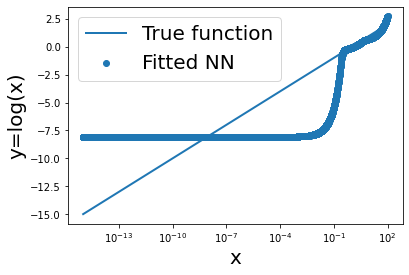

In [31]:
# Scatter the points on the test data set
y_test = torch.sort(torch.rand(N_seq) * (log_V_range[1] - log_V_range[0]) + log_V_range[0]).values
x_test = torch.pow(10., y_test)

y_test_pred = model(x_test.reshape([-1, 1])).detach().reshape(-1)

# Plot the curve
plt.semilogx(x_test, y_test, linewidth=2.0)

plt.xlabel('x', fontsize=20)
plt.ylabel('y=log(x)', fontsize=20)
plt.scatter(x_test.reshape(-1), y_test_pred.reshape(-1).detach())
plt.legend(['True function', 'Fitted NN'], loc='best', fontsize=20)
plt.show()

In [25]:
y_test.shape

torch.Size([12000])